In [1]:
import pandas as pd
import numpy as np

import os
import json

from scipy import stats, special
from matplotlib import pyplot as plt

import generators
import links
import utils
import evaluation

%load_ext autoreload
%autoreload 2


In [2]:
scenarios = pd.read_csv(os.path.join('inputs','scenarios.csv'), index_col='name')
X = pd.read_csv(os.path.join('inputs','weather.csv'), index_col='time')



In [3]:
dx = 5000
def get_mcmc_estimates(params):
    # removes param estimates from burn in period, in case initial estimates were bad
    ix = 0 + dx
    mu, cov = params.iloc[-1*dx:].mean(), params.iloc[-1*dx:].cov()
    while any(np.abs(params[ix:ix+dx].mean()-mu) > 0.01*mu):
        ix += dx
    return params.iloc[ix:].mean(), params.iloc[ix:].cov()

def get_mle_estimates(mu, cov, y, X, return_params=False):
    
    if any(pd.isnull(mu)):
        if return_params:
            return [], []
        else:
            return []
        t_range = []
        for dim in X.keys():
            t_range.append(list(set(np.percentile(X[dim], np.linspace(90,100,21)))))
            
        tvals = np.array(zip(*[p.flatten() for p in np.meshgrid(*t_range)]))
        tvals = pd.DataFrame(tvals, columns=['threshold.%s'%(key) for key in X.keys()], index=range(len(tvals)))
        
        pvals = pd.DataFrame(columns=mu.index)
        events, exog = links.Link().expand_events(X, y)
        for i, t in tvals.iterrows():
            tvals, slopes = links.Link().estimate_params(events, exog, thresholds=dict(t))
            
            p = {'slope': slopes, 'threshold': tvals}
            pvals = pvals.append(pd.io.json.json_normalize(p), ignore_index=True)
            
    else:
    
        p_range = []
        for p in mu.index:
            if cov[p].loc[p] < 0.01:
                p_range.append(np.linspace(mu.loc[p], mu.loc[p], 1))
            else:
                dp = 3*np.sqrt(cov[p].loc[p])
                p_range.append(np.linspace(mu.loc[p]-dp, mu.loc[p]+dp, 30))

        pvals = np.array(zip(*[p.flatten() for p in np.meshgrid(*p_range)]))
        pvals = pd.DataFrame(pvals, columns=mu.index, index=range(len(pvals)))
    
    likelihoods = pd.Series(index=pvals.index)
    for i, params in pvals.iterrows():
        likelihoods.loc[i] = utils.calc_likelihood(params, X, y, links.Link(), 10000)
    if not return_params:
        return pvals.loc[likelihoods.idxmax()]
    else:
        return pvals.loc[likelihoods.idxmax()], {'params': pvals, 'likelihoods': likelihoods}

In [4]:
param_estimates = pd.DataFrame(columns=['scenario','model','estimate',
                                        'Wind.threshold', 'Wind.slope', 
                                        'DayPrecip.threshold','DayPrecip.slope', 
                                        'Precip.threshold','Precip.slope', 
                                        'WindStorm.threshold','WindStorm.slope', 
                                        'var_WindStorm.slope', 'var_WindStorm.threshold',
                                        'var_Wind.slope', 'var_Wind.threshold', 
                                        'var_DayPrecip.slope','var_DayPrecip.threshold',     
                                        'var_Precip.slope','var_Precip.threshold',                                        
                                        'threshold.Wind', 'slope.Wind', 
                                        'threshold.DayPrecip','slope.DayPrecip', 
                                        'threshold.Precip','slope.Precip', 
                                        'threshold.WindStorm','slope.WindStorm', 
                                        'var_slope.WindStorm', 'var_threshold.WindStorm',
                                        'var_slope.Wind', 'var_threshold.Wind', 
                                        'var_slope.DayPrecip','var_threshold.DayPrecip', 
                                        'var_slope.Precip','var_threshold.Precip',                                        
                                       'bic','log_likelihood','aic',
                                       ])

it = 0
for i, row in scenarios.iterrows():
    s = 'scenario%i'%(i)
    true_params = pd.read_csv(os.path.join('scenarios', s, 'parameters.csv'), index_col=0)
    _params = true_params[true_params.keys()[pd.notnull(true_params.iloc[0])]]
    
    y = pd.read_csv(os.path.join('scenarios', s, 'failures.csv'), index_col='time')['count']
    
    mu, cov = _params.mean(), _params.cov()
    
#     result = pd.Series([s, 'true'], index=['scenario','model'])
    
    keys = ['scenario','model','estimate']
    result = [s, 'true','true']
    
    keys.extend(mu.index.tolist())
    result.extend(mu.tolist())
    
    keys.extend(['var_%s'%(p) for p in mu.index])
    result.extend(np.diag(cov).tolist())
    
    param_estimates.loc[it] = pd.Series(result, index=keys)
    it += 1
    
    for model in os.listdir(os.path.join('scenarios', s, 'chains')):
        if model[0] == '.' or model[-3:]=='txt':
            continue
            
#         if len(model.split('+')) > 2:
#             continue
            
        print model
        
        mcmc_params = pd.read_csv(os.path.join('scenarios', s, 'chains', model), index_col=0)
        mcmc_params = mcmc_params[mcmc_params.keys()[:-1]]

        mu, cov = get_mcmc_estimates(mcmc_params)

        keys = ['scenario','model', 'estimate']
        result = [s, model.split('.')[0], 'bhm']

        keys.extend(mu.index.tolist())
        result.extend(mu.tolist())

        keys.extend(['var_%s'%(p) for p in mu.index])
        result.extend(np.diag(cov).tolist())

        param_estimates.loc[it] = pd.Series(result, index=keys)
        it += 1

        x_keys = model.split('.')[0].split('+')
        mle_params, other = get_mle_estimates(mu, cov, y, X[x_keys], return_params=True)
        
        if len(mle_params) == 0:
            continue
            
        likelihood = other['likelihoods'].max()
        
        keys = ['scenario','model','estimate']
        result = [s, model.split('.')[0],'mle']

        keys.extend(mle_params.index.tolist())
        result.extend(mle_params.tolist())

        keys.extend(['var_%s'%(p) for p in mu.index])
        result.extend(np.diag(cov).tolist())
        
        likelihood = other['likelihoods'].max()
        bic = -2*likelihood + len(mle_params) * np.log(len(y))
        aic = 2 * (likelihood - len(mle_params))

        keys.extend(['bic','log_likelihood','aic'])
        result.extend([bic, likelihood, aic])
        
        param_estimates.loc[it] = pd.Series(result, index=keys)
        it += 1
        
    print s

Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv


/Users/laureldunn/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/laureldunn/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/laureldunn/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:7143: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/Users/laureldunn/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/laureldunn/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


scenario1
Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv
scenario2
Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv
scenario3
Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv
scenario4
Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv
scenario5
Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv
scenario6
Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv
scenario7
Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv
scenario8
Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv
scenario9
Wind+DayPrecip.csv
Wind+Precip.csv
Wind.csv
Wind+DayPrecip+WindStorm.csv
Wind+Precip+WindStorm.csv
scenario10
Wind+Day

OSError: [Errno 2] No such file or directory: 'scenarios/scenario19/chains'

In [ ]:
g_x = pd.DataFrame(index=scenarios.index)

it = 0
for i, row in scenarios.iterrows():
    s = 'scenario%i'%(i)
    if i > 12:
        continue
    true_params = pd.read_csv(os.path.join('scenarios', s, 'parameters.csv'), index_col=0)
    _params = true_params[true_params.keys()[pd.notnull(true_params.iloc[0])]]
    
    y = pd.read_csv(os.path.join('scenarios', s, 'failures.csv'), index_col='time')['count']
    
    mu, cov = _params.mean(), _params.cov()
    
    for model in os.listdir(os.path.join('scenarios', s, 'chains')):
        if model[0] == '.' or model[-3:]=='txt':
            continue
                    
        mcmc_params = pd.read_csv(os.path.join('scenarios', s, 'chains', model), index_col=0)
        mcmc_params = mcmc_params[mcmc_params.keys()[:-1]]

        mu, cov = get_mcmc_estimates(mcmc_params)

        x_keys = model.split('.')[0].split('+')
        mle_params, other = get_mle_estimates(mu, cov, y, X[x_keys], return_params=True)
        
        if len(mle_params) == 0:
            continue
            
        likelihood = other['likelihoods'].max()
        
        keys = ['scenario','model','estimate']
        result = [s, model.split('.')[0],'mle']

        keys.extend(mle_params.index.tolist())
        result.extend(mle_params.tolist())

        keys.extend(['var_%s'%(p) for p in mu.index])
        result.extend(np.diag(cov).tolist())
        
        likelihood = other['likelihoods'].max()
        bic = -2*likelihood + len(mle_params) * np.log(len(y))
        aic = 2 * (likelihood - len(mle_params))

        keys.extend(['bic','log_likelihood','aic'])
        result.extend([bic, likelihood, aic])
        
        param_estimates.loc[it] = pd.Series(result, index=keys)
        it += 1
        
    print s

In [7]:
# param_estimates = pd.read_csv(os.path.join('parameters_summary.csv'), index_col=0)
for col in param_estimates.keys():
    if col.split('.')[0] in X.keys():
        idx = pd.notnull(param_estimates[col])
        
        new_col = '.'.join([col.split('.')[1],col.split('.')[0]])
        param_estimates[new_col].loc[idx] = param_estimates[col].loc[idx]
        
        _col = 'var_%s'%(col)
        _new_col = 'var_%s'%(new_col)
        param_estimates[_new_col].loc[idx] = param_estimates[_col].loc[idx]
        
        param_estimates = param_estimates[param_estimates.keys()[~param_estimates.keys().isin([col, _col])]]
param_estimates




,scenario,model,estimate,threshold.Wind,slope.Wind,threshold.DayPrecip,slope.DayPrecip,threshold.Precip,slope.Precip,threshold.WindStorm,...,var_threshold.WindStorm,var_slope.Wind,var_threshold.Wind,var_slope.DayPrecip,var_threshold.DayPrecip,var_slope.Precip,var_threshold.Precip,bic,log_likelihood,aic
0,scenario1,true,true,65.000000,0.200000,NaN,NaN,NaN,NaN,NaN,...,NaN,7.704490e-34,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,scenario1,Wind+DayPrecip,bhm,63.323744,0.199903,1.076821,0.214215,NaN,NaN,NaN,...,NaN,2.076970e-06,0.316118,0.007665,0.002114,NaN,NaN,NaN,NaN,NaN
2,scenario1,Wind+DayPrecip,mle,63.381907,0.199903,1.076821,0.214215,NaN,NaN,NaN,...,NaN,2.076970e-06,0.316118,0.007665,0.002114,NaN,NaN,60102.402585,-30028.440220,-60064.880440
3,scenario1,Wind+Precip,bhm,64.519638,0.199719,NaN,NaN,0.000000e+00,1.368214,NaN,...,NaN,1.157974e-06,0.087349,NaN,NaN,0.587081,0.000000e+00,NaN,NaN,NaN
4,scenario1,Wind+Precip,mle,64.489064,0.199719,NaN,NaN,0.000000e+00,0.813371,NaN,...,NaN,1.157974e-06,0.087349,NaN,NaN,0.587081,0.000000e+00,60102.866343,-30028.672099,-60065.344198
5,scenario1,Wind,bhm,64.280882,0.200505,NaN,NaN,NaN,NaN,NaN,...,NaN,1.903218e-06,0.136201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,scenario1,Wind,mle,64.242704,0.200505,NaN,NaN,NaN,NaN,NaN,...,NaN,1.903218e-06,0.136201,NaN,NaN,NaN,NaN,60081.866656,-30029.552792,-60063.105584
7,scenario1,Wind+DayPrecip+WindStorm,bhm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,scenario1,Wind+Precip+WindStorm,bhm,64.623814,0.199438,NaN,NaN,1.160004e-11,0.495559,0.042819,...,0.000003,2.918676e-06,0.212502,NaN,NaN,0.014179,3.422840e-25,NaN,NaN,NaN
9,scenario1,Wind+Precip+WindStorm,mle,64.576126,0.199438,NaN,NaN,1.160004e-11,0.138332,0.042819,...,0.000003,2.918676e-06,0.212502,NaN,NaN,0.014179,3.422840e-25,60121.898246,-30026.807514,-60065.615029


In [8]:
param_estimates.to_csv('parameters_summary.csv')



In [57]:
param_estimates

,scenario,model,estimate,threshold.Wind,slope.Wind,threshold.DayPrecip,slope.DayPrecip,threshold.Precip,slope.Precip,threshold.WindStorm,...,var_threshold.WindStorm,var_slope.Wind,var_threshold.Wind,var_slope.DayPrecip,var_threshold.DayPrecip,var_slope.Precip,var_threshold.Precip,bic,log_likelihood,aic
0,scenario24,true,true,70.000000,0.200000,0.900000,15.000000,NaN,NaN,NaN,...,NaN,7.704490e-34,0.000000,0.000000,1.232718e-32,NaN,NaN,NaN,NaN,NaN
1,scenario24,Wind+DayPrecip,bhm,22.022360,0.249044,1.394056,19.979409,NaN,NaN,NaN,...,NaN,1.099203e-03,4.546029,5.412267,2.387866e-03,NaN,NaN,NaN,NaN,NaN
2,scenario24,Wind+DayPrecip,mle,15.625934,0.249044,1.394056,13.000125,NaN,NaN,NaN,...,NaN,1.099203e-03,4.546029,5.412267,2.387866e-03,NaN,NaN,32635.067901,-16294.772878,-32597.545756
3,scenario24,Wind,bhm,110.009149,0.160336,NaN,NaN,NaN,NaN,NaN,...,NaN,1.245419e-05,4.232736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,scenario24,Wind,mle,103.837064,0.160336,NaN,NaN,NaN,NaN,NaN,...,NaN,1.245419e-05,4.232736,NaN,NaN,NaN,NaN,47291.192119,-23634.215523,-47272.431047
5,scenario24,Wind+DayPrecip+WindStorm,bhm,69.000000,0.120467,0.978947,4.054060,NaN,NaN,9.947368,...,3.155479e-30,2.794940e-07,0.000000,0.005198,1.232609e-32,NaN,NaN,NaN,NaN,NaN
6,scenario24,Wind+DayPrecip+WindStorm,mle,69.000000,0.120467,0.978947,4.054060,NaN,NaN,9.947368,...,3.155479e-30,2.794940e-07,0.000000,0.005198,1.232609e-32,NaN,NaN,14162.369987,-7047.043384,-14106.086769
7,scenario28,true,true,75.000000,0.200000,0.000000,5.000000,NaN,NaN,NaN,...,NaN,7.704490e-34,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN
8,scenario28,Wind+DayPrecip,bhm,65.000000,0.163861,0.821053,7.150662,NaN,NaN,NaN,...,NaN,4.857539e-07,0.000000,0.006133,1.287488e-29,NaN,NaN,NaN,NaN,NaN
9,scenario28,Wind+DayPrecip,mle,65.000000,0.163861,0.821053,7.150662,NaN,NaN,NaN,...,NaN,4.857539e-07,0.000000,0.006133,1.287488e-29,NaN,NaN,3028.789872,-1491.633863,-2991.267727


# How to evalate model fit?

- Does the chain converge to a stable sampling distribution?

- What is the probability that a particular model is correct?

- How does the posterior compare with the distribution of the data?
    - In expectation
    - statistical distance

- How does the posterior compare with the data-generating process?
    - In expectation
    - statistical distance



In [95]:
scenarios = pd.read_csv(os.path.join('inputs','scenarios.csv'), index_col='name')

X = pd.read_csv(os.path.join('inputs','weather.csv'), index_col='time')

X = X[['Wind','DayPrecip','WindStorm','Precip']]


In [96]:
# summaries = {}

# gridsize = 20

# results = pd.DataFrame()

# cols = ['scenario','model','likelihood','bic','kl','upgrade']
# for key in X.keys():
#     cols.extend(['%s_true_mean'%(key), '%s_true_var'%(key)])
#     cols.extend(['%s_est_mean'%(key), '%s_est_var'%(key)])
# results = pd.DataFrame(columns=cols)
    
# bins = [np.linspace(X[key].min(), X[key].max(), 50) for key in X.keys()]

# x_probs = {}
# x_vals = {}
for keys in [['Wind',],['Wind','DayPrecip'],['Wind','Precip'],['Wind','DayPrecip','WindStorm'], ['Wind','Precip','WindStorm']]:
    print '+'.join(keys)
    if '+'.join(keys) in x_vals.keys():
        continue
    bins = [np.linspace(X[key].min(), X[key].max(), 100) for key in keys]
    p_x, x_bins = np.histogramdd(np.array(X[keys]), bins=bins)
    p_x = (p_x / float(len(X))).flatten()
    
    idx = p_x > 0
    
    x_probs['+'.join(keys)] = p_x[idx]
    
    x_array = np.meshgrid(*[_x[:-1] for _x in x_bins])
    df = pd.DataFrame(zip(*[p.flatten() for p in x_array]), columns=keys)
    x_vals['+'.join(keys)] = df[idx]
        
    print x_probs['+'.join(keys)].shape, x_vals['+'.join(keys)].shape

# results = {}
for s in scenarios.index:
    if s == 19:
        continue
    scenario = 'scenario%i'%(s)
    y = pd.read_csv('scenarios/%s/failures.csv'%(scenario), index_col='time')
    
    print scenario
    with open(os.path.join('scenarios', scenario, 'chains', 'metadata.txt'), 'r') as f:
        meta = f.read()
        
    meta = json.loads('[%s]'%(meta.replace('}{', '},{')))
    
    
    if scenario not in results.keys():

        results[scenario] = {}

        params = pd.read_csv(os.path.join('scenarios', scenario, 'parameters.csv'), index_col=0)
        params = params[params.keys()[pd.notnull(params.loc[0])]]

        for key in params.keys():
            if key.split('.')[0] in X.keys():
                new_label = '%s.%s'%(key.split('.')[1], key.split('.')[0])
                params = params.rename(columns={key: new_label})

        mean, cov = evaluation.param_distributions(params, true=True)
        results[scenario]['means'] = {'true': mean}
        results[scenario]['covs'] = {'true': cov}

        param_vals = evaluation.param_grid(mean, cov)
        results[scenario]['param_vals'] = {'true': param_vals}
        results[scenario]['pdfs'] = {'true': evaluation.param_probs(mean, cov, param_vals)}
        results[scenario]['poisson_probs'] = {'true': evaluation.param_probs(mean, cov, param_vals).flatten()}

    for entry in meta:
        
        model_name = entry.keys()[0]
        model = entry[model_name]
        param_list = model['variables']
        
        if model_name in results[scenario]['poisson_probs'].keys():
            continue
        
        if not os.path.exists(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name))):
            print 'skip reason 1', model_name
            pass
        else:
            params = pd.read_csv(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name)), index_col=0)
            params = params[param_list]

            params = evaluation.fix_naming_issue(params, X.keys())
            mean, cov = evaluation.param_distributions(params)
            if type(mean) == type(np.nan):
                print 'skipping', model_name
                continue
            
            results[scenario]['means'][model_name] = mean
            results[scenario]['covs'][model_name] = cov
            
            param_vals = evaluation.param_grid(mean, cov, gridsize=gridsize)
            results[scenario]['param_vals'][model_name] = param_vals
            results[scenario]['pdfs'][model_name] = evaluation.param_probs(mean, cov, param_vals).flatten()
            
            bin_area = evaluation.calc_grid_area(param_vals, gridsize)
            results[scenario]['pdfs'][model_name] *= bin_area
            
            if np.abs(results[scenario]['pdfs'][model_name].sum() - 1) > 0.01:
#                 print 'here'
                results[scenario]['pdfs'][model_name] = results[scenario]['pdfs'][model_name]/results[scenario]['pdfs'][model_name].sum()

            yvals = np.arange(0,300,1)
            results[scenario]['poisson_probs'][model_name] = pd.Series(0, index=yvals)

            for i, params in param_vals.iterrows():
                p_theta = results[scenario]['pdfs'][model_name][i]
                g_x = links.Link().failure_prob(params, x_vals[model_name])

                y = 0
                while results[scenario]['poisson_probs'][model_name].loc[:y].sum() < 1-1e-10:
                    p_y = (x_probs[model_name]*(np.exp(-1*10000*g_x) * (10000*g_x)**y/(special.factorial(y)))).sum()
                    results[scenario]['poisson_probs'][model_name].loc[y] += p_y * p_theta
                    y += 1

Wind
Wind+DayPrecip
Wind+Precip
Wind+DayPrecip+WindStorm
Wind+Precip+WindStorm
(2279,) (2279, 3)
scenario1


/Users/laureldunn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in double_scalars
/Users/laureldunn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in divide


scenario2
MARKOV CHAIN DID NOT CONVERGE
skipping Wind+DayPrecip


KeyboardInterrupt: 

In [87]:
for s in scenarios.index[:1]:
    scenario = 'scenario%i'%(s)
    if s < 19:
        model_name = 'Wind'
    elif s == 19:
        continue
    else:
        model_name = 'Wind+DayPrecip'

    yvals = np.arange(0,300,1)
    results[scenario]['poisson_probs']['true'] = pd.Series(0, index=yvals)
    
    param_vals = evaluation.param_grid(results[scenario]['means']['true'], 
                                       results[scenario]['covs']['true'], 
                                       gridsize=gridsize)
    
    results[scenario]['pdfs']['true'] = evaluation.param_probs(mean, cov, param_vals).flatten()
    
    for i, params in param_vals.iterrows():
        p_theta = results[scenario]['pdfs']['true'][i]
        g_x = links.Link().failure_prob(params, x_vals[model_name])

        for y in yvals:
            p_y = (x_probs[model_name]*(np.exp(-1*10000*g_x) * (10000*g_x)**y/(special.factorial(y)))).sum()
            results[scenario]['poisson_probs']['true'].loc[y] += p_y * p_theta

slope.Wind         0.2
threshold.Wind    65.0
dtype: float64


In [104]:
for s in results.keys():
    y = pd.DataFrame(columns=results[s]['poisson_probs'].keys(), index=range(300))
    for key in y.keys():
        y[key] = results[s]['poisson_probs'][key]
    y.to_csv(os.path.join('scenarios',s,'poisson_probs.csv'), index=True, index_label='y')
    

In [103]:
pwd

u'/Users/laureldunn/Dropbox/Grid/pscc_paper'

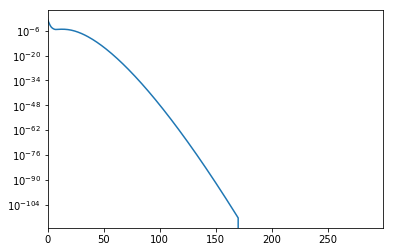

0    0.963007
1    0.035196
2    0.001486
3    0.000151
4    0.000037
5    0.000014
dtype: float64

In [101]:
fig, ax = plt.subplots()
results['scenario5']['poisson_probs']['true'].plot(ax=ax)
ax.set_yscale('log')
plt.show()

results['scenario5']['poisson_probs']['true'].loc[:5]

In [90]:
results['scenario5']['poisson_probs'].keys()



['true', u'Wind']

In [99]:
for s in range(1,24):
    scenario = 'scenario%i'%(s)
    print '\n', scenario
    if scenario not in results.keys():
        continue
    
    for model in results[scenario]['means'].keys():
        
        idx = results[scenario]['poisson_probs']['true'] == np.inf
        results[scenario]['poisson_probs']['true'][idx] = 0
        
        if model not in results[scenario]['poisson_probs'].keys():
            print scenario, model, '\t', results[scenario]['means'][model].loc['threshold.Wind'], '\t', results[scenario]['covs'][model]['threshold.Wind'].loc['threshold.Wind'],'\t', np.nan, '\t', np.nan
            continue
            
        idx = results[scenario]['poisson_probs'][model] == np.inf
        results[scenario]['poisson_probs'][model][idx] = 0
        
        kl_div = []
        for y in results[scenario]['poisson_probs']['true'].index:
            if results[scenario]['poisson_probs']['true'].loc[y] < 1e-10:
                continue
            
            elif results[scenario]['poisson_probs'][model].loc[y] < 1e-10:
                continue
                
            kl_div.append(results[scenario]['poisson_probs']['true'].loc[y] 
                       * np.log(results[scenario]['poisson_probs']['true'].loc[y]
                                /results[scenario]['poisson_probs'][model].loc[y]))            
        print scenario, model, '\t', results[scenario]['means'][model].loc['threshold.Wind'], '\t', results[scenario]['covs'][model]['threshold.Wind'].loc['threshold.Wind'],'\t', len(kl_div), '\t', sum(kl_div)
        
        
        


scenario1
scenario1 Wind+Precip+WindStorm 	64.07990986603753 	7.382841217226456 	0 	0
scenario1 Wind+DayPrecip 	62.97872864745327 	33.1250325532968 	78 	4.401775667247038
scenario1 Wind+DayPrecip+WindStorm 	60.14387366629407 	0.7581062279408382 	78 	nan
scenario1 Wind+Precip 	64.36807633801641 	1.5223477831423322 	0 	0
scenario1 true 	65.0 	0.0 	78 	0.0
scenario1 Wind 	64.17721396571943 	1.182916022456577 	78 	0.0008308934341559367

scenario2
scenario2 Wind+DayPrecip+WindStorm 	55.063493092474985 	17.090021375954443 	94 	nan
scenario2 Wind+Precip+WindStorm 	63.8281701720121 	7.465797878624866 	94 	nan
scenario2 Wind+Precip 	63.672367600465975 	2.5936513898530453 	0 	0
scenario2 true 	64.97234934999996 	2.1945720295405318 	94 	0.0
scenario2 Wind 	63.69678981342485 	1.8970314312513599 	94 	-0.05555536340928572

scenario3
scenario3 Wind+Precip+WindStorm 	63.04381680946232 	3.077866774576409 	nan 	nan
scenario3 Wind+Precip 	62.81075748313416 	0.842664902349848 	0 	0
scenario3 true 	64.944

KeyError: 'true'

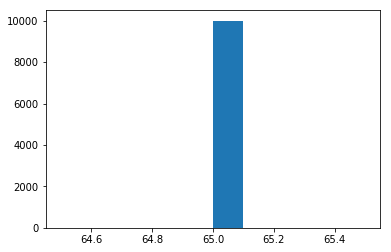

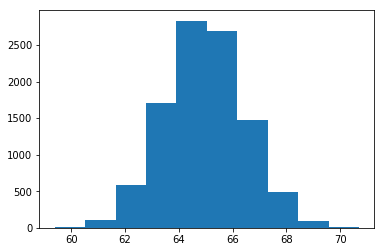

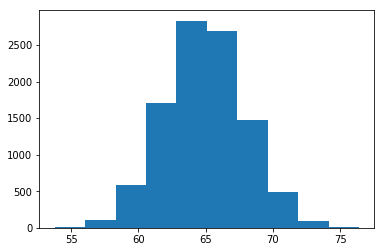

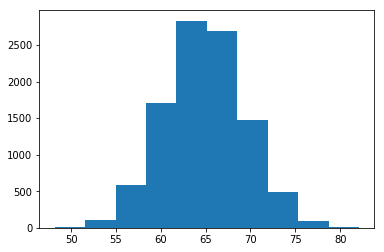

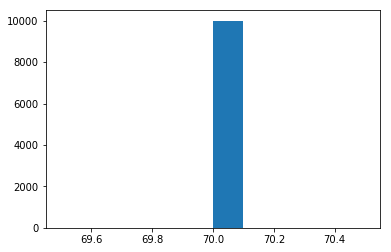

KeyboardInterrupt: 

In [320]:
for i, scenario in scenarios.iterrows():
    params = generators.params(scenario, fleet_size=10000, seed=0)
    params = params[params.keys()[pd.notnull(params.loc[0])]]
    
    h, bins = np.histogram(params['Wind.threshold'].tolist(), bins=100)
    xvals = 0.5*(pd.Series(bins[1:])-pd.Series(bins[:-1]))
    fig, ax = plt.subplots()
    ax.hist(params['Wind.threshold'].tolist())
#     if scenario['Wind.threshold_distribution'] == 'constant':
#         pass
#     else:
#         ax.plot(xvals, stats.norm.pdf(*eval(scenario['Wind.threshold_hyperparams'])))
    plt.show()

# fig, ax = plt.subplots()
# ax.hist(params['Wind.threshold'].tolist())
# ax.set_title('%s, %s'%(np.average(params['Wind.threshold'].tolist()), np.std(params['Wind.threshold'].tolist())))
# plt.show()

In [289]:
meta = '{"Wind": {"variables": ["slope.Wind", "threshold.Wind"], "sigma": [[2.442685569798745e-05, 0.00016710182908722987], [0.00016710182908722987, 0.06301778942747199]], "p0": [0.2983461343324667, 48.04093390540294], "time": "2019-09-21 04:15:05.498296"}}{"Wind+Precip": {"variables": ["slope.Precip", "slope.Wind", "threshold.Precip", "threshold.Wind"], "sigma": [[0.03822267195058332, 7.348828159947663e-05, 0.0, 0.00373740814561864], [7.348828159947663e-05, 2.6678701960190622e-05, 0.0, 0.0003721011034830428], [0.0, 0.0, 0.0, 0.0], [0.00373740814561864, 0.0003721011034830428, 0.0, 0.058792889702554745]], "p0": [1.4153227638927721, 0.31030270614393346, 0.0, 47.495204784227596], "time": "2019-09-21 04:58:30.871477"}}{"Wind+Precip+WindStorm": {"variables": ["slope.Precip", "slope.Wind", "slope.WindStorm", "threshold.Precip", "threshold.Wind", "threshold.WindStorm"], "sigma": [[0.0013486853657569385, -2.1165068095039567e-06, -3.408853957525224e-05, 0.0, 0.0009170375238749073, 8.571169158502491e-07], [-2.1165068095039567e-06, 2.8459644480976764e-05, -2.3315672886515614e-05, 0.0, 0.00017816535843032192, -1.9215839397282606e-07], [-3.408853957525224e-05, -2.3315672886515614e-05, 0.0007036261401256042, 0.0, 0.0020327151460704522, 4.339533288225968e-06], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0009170375238749073, 0.00017816535843032192, 0.0020327151460704522, 0.0, 0.05275169504286983, 2.5879614600133225e-05], [8.571169158502491e-07, -1.9215839397282606e-07, 4.339533288225968e-06, 0.0, 2.5879614600133225e-05, 5.224983901997714e-07]], "p0": [0.5914357583881481, 0.34499497186922473, -0.3529533188737937, 1.667581465998808e-11, 42.38543463129594, 0.002617737775153537], "time": "2019-09-21 05:41:19.296991"}}'

obj = json.loads('[%s]'%(meta.replace('}{', '},{')))
obj[0]

{u'Wind': {u'p0': [0.2983461343324667, 48.04093390540294],
  u'sigma': [[2.442685569798745e-05, 0.00016710182908722987],
   [0.00016710182908722987, 0.06301778942747199]],
  u'time': u'2019-09-21 04:15:05.498296',
  u'variables': [u'slope.Wind', u'threshold.Wind']}}

In [292]:
summaries = {}

results = pd.DataFrame()

cols = ['scenario','model','likelihood','bic','kl','upgrade']
for key in X.keys():
    cols.extend(['%s_true_mean'%(key), '%s_true_var'%(key)])
    cols.extend(['%s_est_mean'%(key), '%s_est_var'%(key)])
results = pd.DataFrame(columns=cols)
    
xvals = np.arange(1,150,10)
wind_hist = np.histogram(X['Wind'].tolist(), bins=xvals)
wind_hist = pd.Series(wind_hist[0], xvals[:-1])

results = {}
for s in scenarios.index:
    scenario = 'scenario%i'%(s)
    y = pd.read_csv('scenarios/%s/failures.csv'%(scenario), index_col='time')

    with open(os.path.join('scenarios', scenario, 'chains', 'metadata.txt'), 'r') as f:
        meta = f.read()
        
    meta = json.loads('[%s]'%(meta.replace('}{', '},{')))
    
    results[scenario] = {}
    
    params = pd.read_csv(os.path.join('scenarios', scenario, 'parameters.csv', index=0))
    params = params[params.keys()[pd.notnull(params.loc[0])]]
    
    mean, cov = evaluation.param_distributions(params, true=True)
    results[scenario]['means'] = {'true': mean}
    results[scenario]['covs'] = {'true': cov}
    
    for entry in meta:
        
        model_name = entry.keys()[0]
        model = entry[model_name]
        param_list = model['variables']
        
        if not os.path.exists(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name))):
            pass
        else:
            params = pd.read_csv(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name)), index_col=0)
            params = mcmc_params[param_list]
            
            mean, cov = evaluation.param_distributions(params)
            results[scenario]['means'] = {model_name: mean}
            results[scenario]['covs'] = {model_name: cov}
        
#     grid_lims = {}
#     for model in results[scenario]['means'].keys():
#         for param in results[scenario]['means'][model].index:
#             if param not in grid_lims.
#             mean = results[scenario]['means'][model].loc[param]
#             std = np.sqrt(results[scenario]['covs'][model][param].loc[param])
#             mins.append(mean - 5*std)
#             maxs.append(mean + 5*std)
#         grid_lims
        
    grid_lims = [results[scenario]['means']-5*np.sqrt(np.diag(results[scenario]['covs']))]
            
            
            logL = pd.Series()
            for i in np.arange(5000,len(mcmc_params), 100):
                logL.loc[i] = utils.calc_likelihood(mcmc_params.loc[i], X, y['count'], links.Link(), 10000)
            
            result['likelihood'] = np.average(logL)
            result['bic'] = np.log(len(y))*len(model_name.split('+')) - 2*np.average(logL)
            
            for key in mcmc_params.keys():
                result['%s_est_mean'%(key)] = mcmc_params[key].mean()
                result['%s_est_std'%(key)] = mcmc_params[key].std()
            
            for key in true_params.keys():
                result['%s_true_mean'%(key)] = true_params[key].mean()
                result['%s_true_std'%(key)] = true_params[key].std()
            
            
            bins = np.array(zip(*[p.flatten() for p in grid]))
            probs[s][model_name] = {'true': stats.multivariate_normal.pdf(bins, mean=, cov=),
                                   'est': stats.multivariate_normal.pdf(bins, mean=true_mean, cov=),
                                   'bins': bins}
            
    summaries[scenario] = summary
        

KeyboardInterrupt: 

# Choose the model that's most likely

The problem with this approach is that my system is over parameterized. The data generating process is just a constant. Models with more parameters aren't less likely, the likelihood is about the same (obviously), but they don't provide meaningful insights. 

Looking at plots in 5.2, over parameterized models have unstable sampling distributions in the markov chain. Would it make sense to choose a model based on sampling stability, rather than likelihood?

**Scott tip:** Learn about Fisher Information
https://en.wikipedia.org/wiki/Fisher_information

In [280]:
results = pd.DataFrame(columns=['scenario','model','alpha_mean','alpha_var','beta_mean','beta_var','bic','kl','upgrade'])


model_selection = []

for s in scenarios.index:
    scenario = 'scenario%i'%(s)
    best_bic = summaries[scenario]['bic'].idxmin()
    
    df = pd.DataFrame(index=summaries[scenario]['bic'])
    
    df['alpha'] = scenarios['Wind.threshold'].loc[s]
    df['\hat{alpha}'] = _params['mean'].loc['threshold.Wind']
    
    df['beta'] = scenarios['Wind.slope'].loc[s]
    df['\hat{beta}'] = _params['mean'].loc['slope.Wind']
    
    df['bic'] = summaries[scenario]['bic']-best_bic
    
    _params = summaries[scenario]['params'][summaries[scenario]['bic'].idxmin()]
    _params = _params[pd.notnull(_params.loc[0])]
    
    p_mean = _params.mean()
    p_cov = _params.cov()
    
#     grids = [np.linspace(p_mean[i]-5*np.sqrt(p_cov[i].loc[i]), 
#                          p_mean[i]-5*np.sqrt(p_cov[i].loc[i]), 
#                          100) 
#              for i in _params.keys()]
    
#     p_vals = np.meshgrid(*grids)
#     pdf = stats.multivariate_normal.pdf(p_vals, mean=p_mean, cov=p_cov)
    
#     probs = pd.DataFrame(columns=['true','estimate'], index=range(1e5))
#     for y in probs.index:
        
    
    print (s, '\t', 
           np.round(_params['mean'].loc['threshold.Wind'],0), '\t',
           np.round(np.sqrt(_params['var'].loc['threshold.Wind'],0)), '\t',
           np.round(_params['mean'].loc['slope.Wind'],0), '\t',
           np.round(np.sqrt(_params['mean'].loc['slope.Wind'],0)), '\t',
           
          )
    
    _params = summaries[scenario]['mcmc'].loc[np.arange(5000,len(summaries[scenario]['mcmc']),10)]
    print _params.mean().loc['threshold.Wind'], np.sqrt(_params.var().loc['threshold.Wind'])


SyntaxError: invalid syntax (<ipython-input-280-a2d1e0a68406>, line 8)

ValueError: zero-size array to reduction operation minimum which has no identity

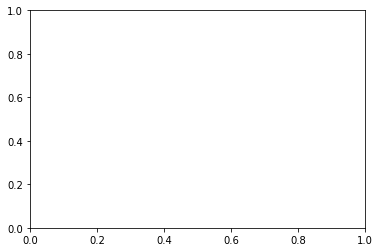

In [82]:
estimated = []
true = []
for s, row in scenarios.iterrows():
    scenario = 'scenario%s'%(s)
    if scenario in summaries.keys():
        estimated.append(summaries[scenario]['mcmc'].loc[np.arange(5000,len(summaries[scenario]['mcmc']),10)])
        true.append(generators.params(row, fleet_size=10000, seed=0))

fig, ax = plt.subplots()
ax.violinplot([t['Wind.threshold'].tolist() for t in true], np.arange(len(true)), widths=0.3)
ax.violinplot([e['threshold.Wind'].tolist() for e in estimated], np.arange(len(estimated))+0.3, widths=0.3)
ax.hist([], histtype='stepfilled', color='amber', alpha=0.5, label=r'Estimated')
ax.hist([], histtype='stepfilled', color='windows blue', alpha=0.5, label=r'True')
plt.legend()
plt.show()

# n = range(0,100)
# x = np.arange(0,150)
# p_x = stats.norm.pdf(x, X['Wind'].mean(), np.std(X['Wind']))

# prob_true = pd.DataFrame(0, columns=range(len(true)), index=x)
# prob_est = pd.DataFrame(0, columns=range(len(true)), index=x)
# fig, ax = plt.subplots()
# for i, (t, e) in enumerate(zip(true, estimated)):
#     for j, _t in t.iterrows():
#         prob_true[i] += 1./(1+np.exp(-1*_t['Wind.slope']*(x-_t['Wind.threshold'])))
    
#     for j, _e in e.iterrows():
#         prob_est[i] += 1./(1+np.exp(-1*_e['slope.Wind']*(x-_e['threshold.Wind'])))



/Users/laureldunn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


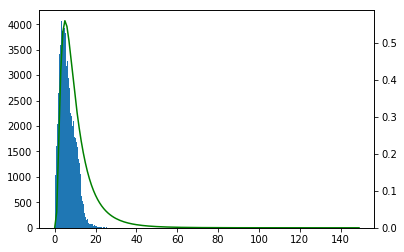

In [238]:
n = range(0,100)
x = np.arange(0,150)
p_x = stats.norm.pdf(np.log(x), np.log(X['Wind']).mean(), np.std(np.log(X['Wind'])))

fig, ax = plt.subplots()
ax.hist(X['Wind'].tolist(), bins=100)
ax2 = plt.twinx()
ax2.plot(x, p_x, color='g')
ax2.set_ylim(0,ax2.get_ylim()[1])
plt.show()

0


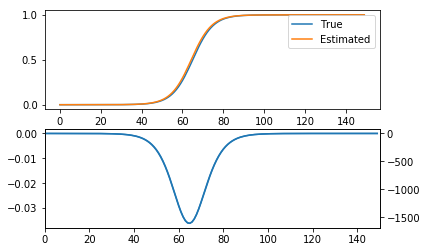

1


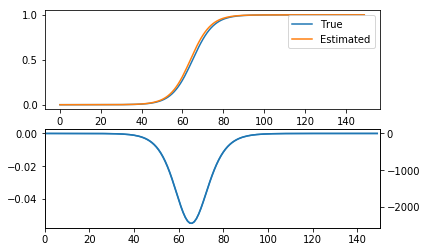

2


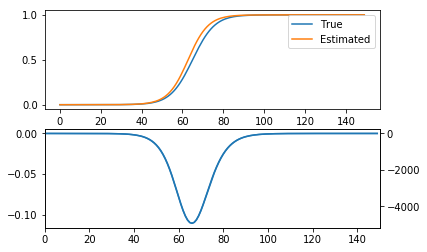

3


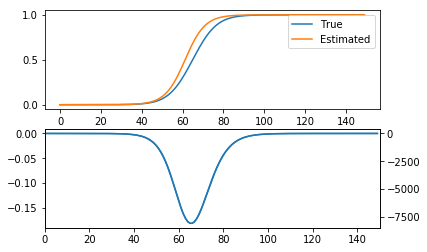

4


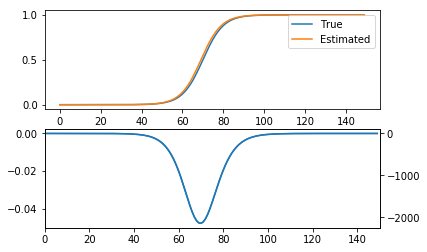

5


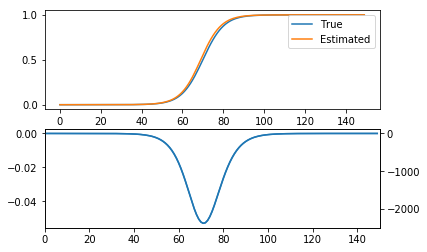

6


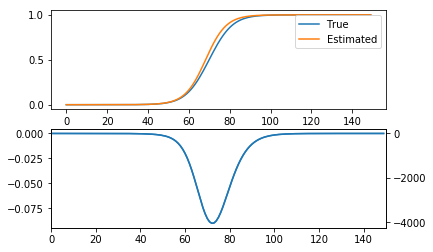

7


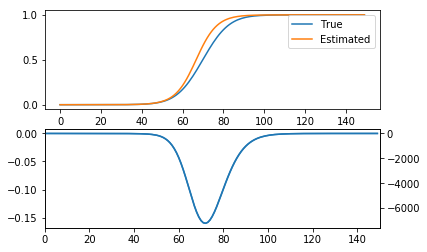

8


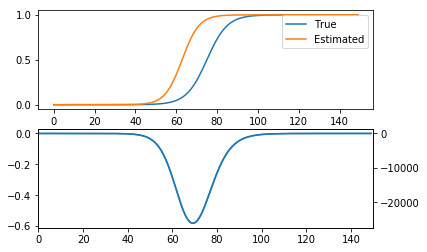

9


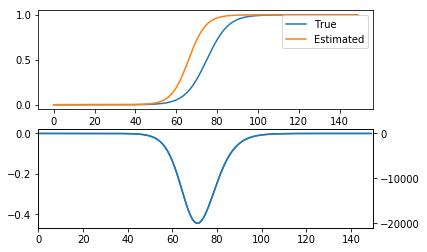

10


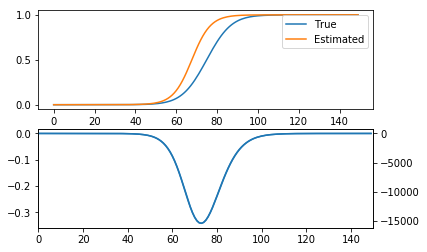

11


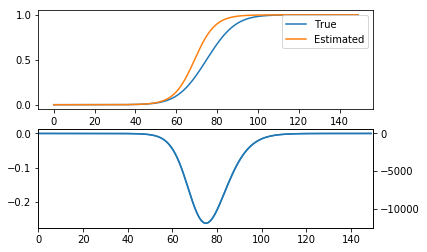

In [254]:
metrics = pd.DataFrame(columns=['threshold','cov','kl divergence','ks test','shortfall','upgrades'], index=prob_true.keys())
for key in prob_true.keys():
    print key
    prob_true[key] = prob_true[key]/prob_true[key].max()
    prob_est[key] = prob_est[key]/prob_est[key].max()
    
    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(x, prob_true[key], label='True')
    ax[0].plot(x, prob_est[key], label='Estimated')
    ax[0].legend()
    
    ax[1].plot(x, prob_true[key]-prob_est[key], label='difference')
    ax[1].set_xlim(0,150)

    ax2 = ax[1].twinx()
    
    p_x = stats.lognorm.pdf(x, X['Wind'].mean(), np.std(X['Wind']))
    ax2.plot(x, 1e5*p_x.cumsum()*(prob_true[key]-prob_est[key]), label='risk')
    ax2.set_xlim(0,150)
    plt.show()
    
#     metrics['mean'] = 
    metrics['kl divergence'].loc[key] = sum(prob_true[key]*(np.log(prob_true[key]) - np.log(prob_est[key])))
    metrics['ks test'].loc[key] = 8760*max(np.abs(prob_true[key]-prob_est[key]))
    metrics['shortfall'].loc[key] = 8760*sum(p_x*(prob_true[key] - prob_est[key]))


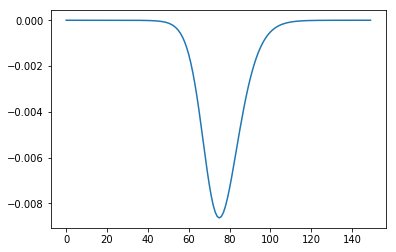

In [251]:
_p_x = (1-p_x.cumsum())*(prob_true[key] - prob_est[key])
fig, ax = plt.subplots()
ax.plot(x, _p_x)

In [247]:
metrics['shortfall'] *= 8760
metrics

,kl divergence,ks test,shortfall,upgrades
0,-0.694762,0,-0.0110877,NaN
1,-1.04205,0,-0.0110906,NaN
2,-2.02795,0,-0.0103118,NaN
3,-3.26011,0,-0.00816562,NaN
4,-0.902925,0,-0.00277308,NaN
5,-1.00196,0,-0.00371346,NaN
6,-1.63626,0,-0.00579529,NaN
7,-2.96694,0,-0.0103051,NaN
8,-6.85798,3.55354e-07,0.00217758,NaN
9,-6.05756,3.95695e-06,0.00676431,NaN


In [106]:
model_name = bic.idxmin()
mcmc_params = pd.read_csv(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name)), index_col=0)
mcmc_params = mcmc_params.loc[5000:]

In [107]:
fleet_size = 10000
xvals = np.arange(0,150)

H = np.histogramdd(np.array(mcmc_params), bins=100)
bins = np.meshgrid(*[a[:-1] for a in H[1]])

print sum(H[0].flatten()), max(H[0].flatten())

df = pd.DataFrame(index=H[0].flatten().astype(float)/H[0].sum(), columns=mcmc_params.keys())
for i, col in enumerate(mcmc_params):
    df[col] = bins[i].flatten()
    
idx = df.index > 0
df = df[idx]
print len(df)

failures = pd.Series(0, index=X.index)
for wt, params in df.iterrows():
    exp = pd.Series(0, index=X.index)
    for dim in X.keys():
        if 'slope.%s'%(dim) in params.keys():
            exp += params['slope.%s'%(dim)]*(X[dim]-params['threshold.%s'%(dim)])
    failures += wt * fleet_size / (1. + np.exp(-1*exp))



45001.0 446.0
1212


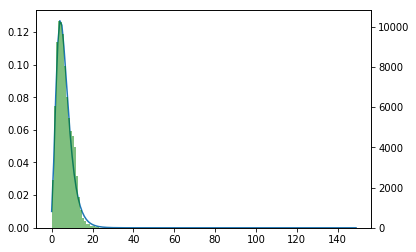

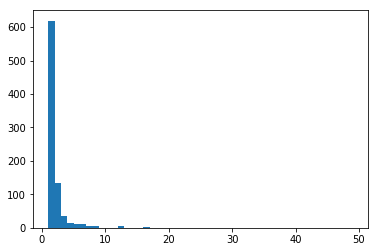

In [110]:
p_x = stats.lognorm.pdf(xvals, *stats.lognorm.fit(X['Wind']))

fig, ax = plt.subplots()
ax.plot(xvals, p_x)
ax.set_ylim(0, ax.get_ylim()[1])
ax2 = ax.twinx()
ax2.hist(X['Wind'], bins=xvals, color='g', alpha=0.5)
# ax.set_xscale('log')
plt.show()

fig, ax = plt.subplots()
ax.hist(failures.tolist(), bins=range(1,50))
plt.show()

# fig, ax = plt.subplots()
# ax.plot(xvals[:-1], p_x[:-1]*np.histogram(failures, xvals)[0])
# ax.set_yscale('log')
# plt.show()

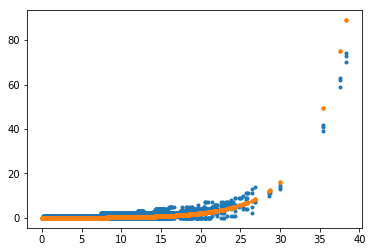

In [109]:
fig, ax = plt.subplots()
ax.plot(X['Wind'].tolist(), y['count'].tolist(), ls=' ', marker='.')
ax.plot(X['Wind'].tolist(), failures.tolist(), ls=' ', marker='.')
plt.show()

In [85]:
# Contour plot showing P(Y=y|x)
# Histogram showing upgrade policy
# Plot contour of logistic functions - actual and estimated

,count,rate
time,,
0,0.0,0.070252
1,0.0,0.048818
2,0.0,0.044084
3,0.0,0.046623
4,0.0,0.048043


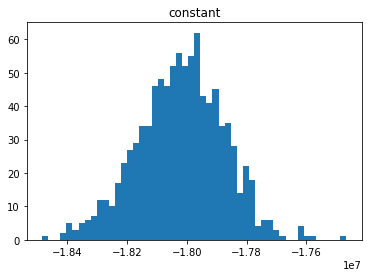

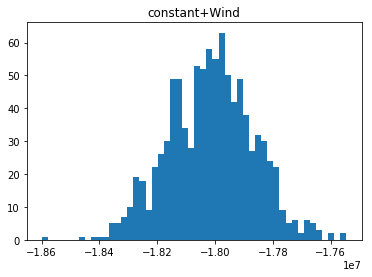

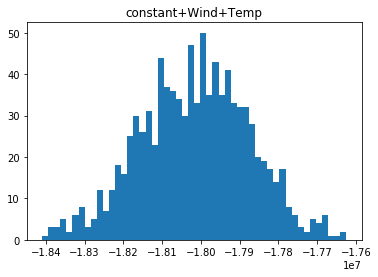

In [15]:
for key in likelihoods.keys():
    fig, ax = plt.subplots()
    ax.hist(likelihoods[key], bins=50)
    ax.set_title(key)
    plt.show()

In [7]:
bic = pd.Series(index=likelihoods.index)

n = len(y)
for model_name in bic.index:
    k = 2*len(model_name.split('+'))
    bic.loc[model_name] = np.log(n)*y - 2*likelihoods.loc[model_name]

print bic.sort_values()


pd.DataFrame(likelihoods).mean().sort_values()


ValueError: Incompatible indexer with DataFrame

In [9]:
likelihoods

constant              5000     -1.825927e+07
5100     -1.787837e+07
...
constant+Wind         5000     -1.800790e+07
5100     -1.788693e+07
...
constant+Wind+Temp    5000     -1.814516e+07
5100     -1.791683e+07
...
dtype: object

-1578.1620113271558

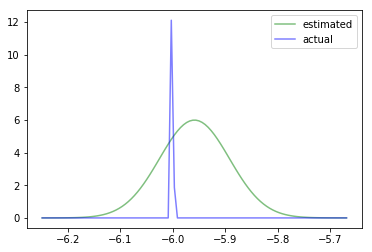

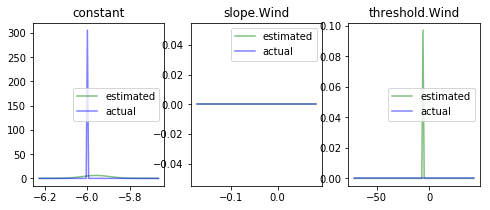

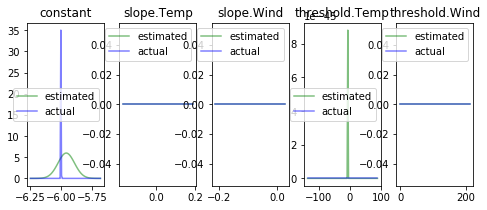

In [111]:
y = pd.read_csv('scenarios/scenario0/failures.csv', index_col='time')

for entry in meta:
    model_name = entry.keys()[0]
    model = entry[model_name]
    
    param_list = model['variables']
    mcmc_params = pd.read_csv(os.path.join('scenarios', 'scenario0', 'chains', '%s.csv'%(model_name)), index_col=0)
        
    if len(param_list) == 1:
        p = param_list[0]

        fig, ax = plt.subplots()
        bins = np.linspace(mcmc_params[p].loc[1000:].min(), mcmc_params[p].loc[1000:].max(), 100)
        
        estimated = stats.norm.fit(mcmc_params[p].loc[1000:].tolist())
        actual = stats.norm.fit(params[p].tolist())

        ax.plot(bins, stats.norm.pdf(bins, *estimated), color='g', alpha=0.5, label='estimated')
        ax.plot(bins, stats.norm.pdf(bins, *actual), color='b', alpha=0.5, label='actual')
        
        ax.legend()

    else:
        fig, ax = plt.subplots(figsize=(8,3), ncols=len(param_list))
    
        for i, p in enumerate(param_list):
            bins = np.linspace(mcmc_params[p].loc[1000:].min(), mcmc_params[p].loc[1000:].max(), 100)

            ax[i].plot(bins, stats.norm.pdf(bins, *estimated), color='g', alpha=0.5, label='estimated')
            ax[i].plot(bins, stats.norm.pdf(bins, *actual), color='b', alpha=0.5, label='actual')
            ax[i].set_title(p)
            
            ax[i].legend()
    plt.show()

In [102]:
np.log(failures.mean())

count   -3.840446
rate    -3.789622
dtype: float64

KeyboardInterrupt: 

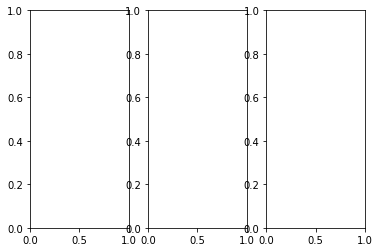

In [27]:
fig, ax = plt.subplots(ncols=len(X.keys()))

for i, key in enumerate(X.keys()):
    x_vals = np.linspace(X[key].min(), X[key].max(), 100)
    x_in = X.mean()*pd.DataFrame(1, columns=X.keys(), index=range(len(x_vals)))
    x_in[key] = x_vals
            
    rates = pd.DataFrame(index=_params.index, columns=x_vals)
    for j in params.index:
        rates.loc[j] = links.Link().failure_rate(_params.loc[j], x_in)
        
    for key in rates.keys():
        ax[i].plot(key*np.ones(len(rates),), rates[key].tolist(), ls=' ', marker='.', color='g', alpha=0.1)
plt.show()

In [26]:
x_in = X.mean()*pd.DataFrame(1, columns=X.keys(), index=range(100))


In [23]:
x_in.head()

,Wind,Precip,Temp
0,6.286487,0.001303,58.068202
1,6.286487,0.001303,58.068202
2,6.286487,0.001303,58.068202
3,6.286487,0.001303,58.068202
4,6.286487,0.001303,58.068202


In [66]:
params = pd.read_csv('parameters_summary.csv', index_col=0)

x_vals = np.linspace(0,300,1000)
dx = np.abs(x_vals[-1] - x_vals[-2])
x_prob = stats.lognorm.pdf(x_vals, *stats.lognorm.fit(X['Wind']))
x_prob = x_prob / (dx * x_prob.sum())

# x_vals = np.linspace(1,150,300)
# x_prob = stats.lognorm.pdf(x_vals, *stats.lognorm.fit(X['Wind']))
# dx = np.abs(x_vals[-2]-x_vals[-1])

taus = pd.DataFrame(0, index=params.index, columns=[100,10,1])
components = pd.DataFrame(0, index=params.index, columns=[100,10,1])

y_vals = np.arange(1000)
_p_y = pd.DataFrame(0, columns=params.index, index=y_vals)
for i, row in params.iterrows():
    if row['model'] not in ['Wind','true']:
        continue
#     if sum(p_y[i]>0):
#         continue
    beta = row['slope.Wind']
    alpha_mu = row['threshold.Wind']
    alpha_var = row['var_threshold.Wind']

    if row['model'] == 'Wind+Precip':
        continue

    if alpha_var < 1e-2 or pd.isnull(alpha_var) or row['estimate'] == 'mle':
        continue
        a_vals = np.linspace(alpha_mu, alpha_mu, 1)
        a_prob = np.ones(a_vals.shape)
        da = 1
        
    else:
        a_vals = np.linspace(alpha_mu-5*np.sqrt(alpha_var), alpha_mu+5*np.sqrt(alpha_var), 100)
        a_prob = stats.norm.pdf(a_vals, alpha_mu, np.sqrt(alpha_var))
        da = np.abs(a_vals[-2]-a_vals[-1])
        
    xx, aa = np.meshgrid(x_vals, a_vals)
    xx, aa = xx.flatten(), aa.flatten()
    
    p_x, p_a = np.meshgrid(x_prob, a_prob)
    p_x, p_a = p_x.flatten(), p_a.flatten()
    
    p_fail = 1./(1.+np.exp(-1*beta*(xx-aa)))
    lam = 10000*p_fail
    
    for y in y_vals:
        n_fail = np.exp(-1*lam + y*np.log(lam) - np.log(special.factorial(y)))
        _p_y[i].loc[y] = (p_x * p_a * n_fail * da * dx).sum()
    
#     for p_a, a in zip(a_prob, a_vals):
#         p_fail = 1 / (1.+np.exp(-1*beta*(x_vals-a)))
#         lam = 10000 * p_fail
        
#         for y in y_vals:
#             n_fail = (np.exp(-1*lam)*(lam**y/special.factorial(y)))
            
#             if pd.isnull((p_a * x_prob * n_fail * da * dx).sum()):
#                 break
#                 break
#                 break
#             p_y[i].loc[y] += (p_a * x_prob * n_fail * da * dx).sum()
    
    print row['estimate'], _p_y[i].sum()
#     print i, p_y[i].sum()
#     for delta in taus.keys():
#         p_y_tilde = np.array(p_y[i])
        
#         print delta, p_y[i][p_y.index>delta].sum()
        
#         if 8760 * 100 * p_y_tilde[delta:].sum() <= 1:
#             continue

#         if len(a_vals) == 1:
#             a = a_vals[0]
#             p_fail = x_prob * 1 / (1.+np.exp(-1*beta*(x_vals-a)))
#             upgrade = 0
#             lam = (10000-upgrade) * p_fail.sum() * dx
#             p_y_tilde = p_y[i]
#             while 8760 * 100 * p_y_tilde[delta:].sum() > 1:
#                 upgrade += 1
#                 lam = (10000-upgrade) * p_fail.sum() * dx
#                 p_y_tilde = (np.exp(-1*lam)*(lam**y_vals/special.factorial(y_vals)))
#             taus[delta].loc[i] = np.nan
#             components[delta].loc[i] = upgrade
#         else:
#             while 8760 * 100 * p_y_tilde[delta:].sum() > 1:
#                 p_y_tilde = np.zeros((len(y_vals,)))
#                 a_vals = a_vals[1:]
#                 a_prob = a_prob[1:]
#                 for p_a, a in zip(a_prob, a_vals):
#                     p_fail = x_prob * 1 / (1.+np.exp(-1*beta*(x_vals-a)))
#                     lam = 10000 * p_fail.sum() * dx
#                     n_fail = (np.exp(-1*lam)*(lam**y_vals/special.factorial(y_vals)))
#                     p_y_tilde += (p_a * n_fail) * da
# #                 print delta, 8760 * 100 * p_y_tilde[delta:].sum()
                
#             taus[delta].loc[i] = a_vals[0]
#             components[delta].loc[i] = 10000*(1-sum(a_prob))
            

#             if len(a_prob) > 1:
#                 fig, ax = plt.subplots()
#                 ax.plot(a_vals, a_prob)
#                 plt.show()


bhm 0.9999902326727387
true 0.9999910513496725
bhm 0.9999894613188113
true 0.9999891032053212
bhm 0.999986934402324
true 0.9999846390040493
bhm 0.9999822206096821
bhm 0.9999966136243214
true 0.9999967812302422
bhm 0.9999964050435883
true 0.999995668300815
bhm 0.9999956667215423
true 0.9999924526891881
bhm 0.9999937001077933
bhm 0.9999970790621485
true 0.9999985998350748
bhm 0.9999971219426863
true 0.9999979939320051
bhm 0.9999967680999345
true 0.999995656846424
bhm 0.9999964868519655
true 0.9999925350773242
bhm 0.9999922366881722
true 0.9999919535550771
bhm 0.9999915001870642
true 0.9999899387410465
bhm 0.9999892674820355
true 0.9999782097339225
bhm 0.9999594676848622
true 0.9999760032684564
bhm 0.9999570568935251
true 0.9999690376250834
bhm 0.9999537988481682


In [114]:


results = pd.DataFrame(columns=['scenario','method','mean','var','KLD','kld_g','delta=0.1','delta=0.2','delta=0.01'])

for i in p_y.keys():
    row = param_estimates.loc[i]
    
    idx = (param_estimates['scenario']==row['scenario']) & (param_estimates['model']=='true')
    true_ix = param_estimates[idx].index[0]
    
    idx = (p_y[true_ix]>0) | (p_y[i]>0)
    div = np.average((p_y[true_ix] * (np.log(p_y[true_ix]) - np.log(p_y[i])))[idx])
    div_g = np.average((g_x[true_ix] * (np.log(g_x[true_ix]) - np.log(g_x[i]))))

    if int(row['scenario'].replace('scenario',''))>=13:
        continue
    if p_y[i].sum()==0:
        continue
    if row['model'] == 'true':
        print '\n'
    results.loc[len(results)] = [row['scenario'], row['estimate'], 
                                 np.round(row['threshold.Wind'],2), 
                                 np.round(np.sqrt(row['var_threshold.Wind']),3), 
                                 div, 
                                 div_g,
                                 np.round(8760*(1-p_y[i].loc[:10].sum()),2),
                                 np.round(8760*(1-p_y[i].loc[:20].sum()),2),
                                 np.round(8760*(1-p_y[i].loc[:100].sum()),2)
                                ]
#     print i, row['model'], row['estimate'], np.round(row['threshold.Wind'],2), np.round(8760*(1-p_y[i].loc[:10].sum()),2), 1000*div


/Users/laureldunn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/Users/laureldunn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [115]:
results.to_csv('results2.csv')

In [113]:
params = pd.read_csv('parameters_summary.csv', index_col=0)

x_vals = np.linspace(0,150,300)
dx = np.abs(x_vals[-1] - x_vals[-2])
x_prob = stats.lognorm.pdf(x_vals, *stats.lognorm.fit(X['Wind']))
x_prob = x_prob / (dx * x_prob.sum())

g_x = pd.DataFrame(0, columns=params.index, index=x_vals)

for i, row in params.iterrows():
    if row['model'] not in ['Wind','true']:
        continue
#     if sum(p_y[i]>0):
#         continue
    beta = row['slope.Wind']
    alpha_mu = row['threshold.Wind']
    alpha_var = row['var_threshold.Wind']

    if row['model'] == 'Wind+Precip':
        continue

    if alpha_var < 1e-2 or pd.isnull(alpha_var) or row['estimate'] == 'mle':
        a_vals = np.linspace(alpha_mu, alpha_mu, 1)
        a_prob = np.ones(a_vals.shape)
        da = 1
        
    else:
        a_vals = np.linspace(alpha_mu-5*np.sqrt(alpha_var), alpha_mu+5*np.sqrt(alpha_var), 100)
        a_prob = stats.norm.pdf(a_vals, alpha_mu, np.sqrt(alpha_var))
        da = np.abs(a_vals[-2]-a_vals[-1])
        
    xx, aa = np.meshgrid(x_vals, a_vals)
    xx, aa = xx.flatten(), aa.flatten()
    
    p_x, p_a = np.meshgrid(x_prob, a_prob)
    p_x, p_a = p_x.flatten(), p_a.flatten()
    
    p_fail = 1./(1.+np.exp(-1*beta*(xx-aa)))
    
    df = pd.DataFrame(index=range(len(p_fail)))
    df['x'] = xx
    df['g'] = p_a * p_fail * da
    g_x[i] = df.groupby('x')['g'].sum()
    
    print row['estimate'], g_x[i].max()


true 0.9999999586006244
bhm 0.9999995298483819
mle 0.9999999659276391
true 0.9999995212583891
bhm 0.9999995342621899
mle 0.9999999702692426
true 0.9999995154749383
bhm 0.9999995443801359
mle 0.9999999802694184
true 0.9999995038348422
bhm 0.9999995524171152
mle 0.9999999882197511
true 0.9999998874648379
bhm 0.9999994796657787
mle 0.9999999173762929
true 0.9999994435029335
bhm 0.999999477208217
mle 0.9999999143313814
true 0.9999994127707748
bhm 0.9999994760777358
mle 0.9999999113362964
true 0.9999993421268278
bhm 0.999999489860549
mle 0.9999999265249119
true 0.999999694097773
bhm 0.9999995618441461
mle 0.9999999976679907
true 0.9999992218811916
bhm 0.9999995595380666
mle 0.9999999954081396
true 0.9999990752145667
bhm 0.999999550781803
mle 0.9999999867992186
true 0.9999986729460489
bhm 0.9999994642739406
mle 0.9999999017761424
true 0.9999995094996874
bhm 0.9999995101336231
mle 0.9999999464733937
true 0.9999995069484472
bhm 0.9999995191757602
mle 0.9999999553742824
true 0.9999994979162579


In [109]:
g_x

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0.000000,0.000002,0,0,0,0,0.000003,0.000003,0,0,0,...,0,0.000006,0.000006,0,0.000005,0,0.000006,0.000006,0,0.000002
0.501672,0.000002,0,0,0,0,0.000003,0.000003,0,0,0,...,0,0.000007,0.000007,0,0.000006,0,0.000007,0.000007,0,0.000002
1.003344,0.000003,0,0,0,0,0.000003,0.000003,0,0,0,...,0,0.000007,0.000007,0,0.000006,0,0.000008,0.000008,0,0.000003
1.505017,0.000003,0,0,0,0,0.000003,0.000003,0,0,0,...,0,0.000008,0.000008,0,0.000007,0,0.000009,0.000009,0,0.000003
2.006689,0.000003,0,0,0,0,0.000004,0.000004,0,0,0,...,0,0.000009,0.000009,0,0.000008,0,0.000010,0.000010,0,0.000003
2.508361,0.000004,0,0,0,0,0.000004,0.000004,0,0,0,...,0,0.000010,0.000010,0,0.000009,0,0.000011,0.000011,0,0.000004
3.010033,0.000004,0,0,0,0,0.000005,0.000005,0,0,0,...,0,0.000011,0.000011,0,0.000010,0,0.000012,0.000012,0,0.000004
3.511706,0.000005,0,0,0,0,0.000005,0.000005,0,0,0,...,0,0.000013,0.000013,0,0.000011,0,0.000013,0.000013,0,0.000005
4.013378,0.000005,0,0,0,0,0.000006,0.000006,0,0,0,...,0,0.000014,0.000014,0,0.000012,0,0.000015,0.000015,0,0.000005
4.515050,0.000006,0,0,0,0,0.000006,0.000006,0,0,0,...,0,0.000016,0.000016,0,0.000013,0,0.000017,0.000017,0,0.000006


In [57]:
p_y.index.max()

999

In [49]:
p_y.index.max()

999

In [16]:
idx = pd.notnull(p_y[0])
print (p_y[0][idx]*(np.log(p_y[0][idx])-np.log(p_y[5][idx]))).sum()
print (p_y[0][idx]*(np.log(p_y[0][idx])-np.log(p_y[6][idx]))).sum()
# param_estimates['threshold.Wind']


0.002832473260440304
0.0029189525582389055


In [41]:
p_y

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,9.000329e-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8.652041e-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.473355e-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.008112e-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7.345460e-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3.615099e-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2.097453e-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.348375e-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9.296716e-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,6.744304e-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
p_y.head() * 8760 * 100

for delta in [0.01, 0.001, 0.0001]:
    n = 10000*delta
    print delta, sum(8760 * 100 * p_y.loc[n] > 1)


0.01 0
0.001 6
0.0001 73


In [199]:
params['kl_div'] = 0
params['average'] = 0
for scenario in params['scenario'].unique():
    print scenario
    idx = params['scenario'] == scenario
    true = params[idx & (params['estimate'] == 'true')].index[0]
    
    idx = idx & (params['model']=='Wind')
    try:
        mle = params[idx & (params['estimate'] == 'mle')].index[0]
    except IndexError:
        pass
    try:
        bhm = params[idx & (params['estimate'] == 'bhm')].index[0]
    except IndexError:
        pass
    print true, mle, bhm
    params['kl_div'].loc[mle] = sum(p_y[true]*(np.log(p_y[true])-np.log(p_y[mle])))
    params['kl_div'].loc[bhm] = sum(p_y[true]*(np.log(p_y[true])-np.log(p_y[bhm])))
    
    params['average'].loc[true] = (p_y[true] * p_y.index).sum()
    params['average'].loc[mle] = (p_y[mle] * p_y.index).sum()
    params['average'].loc[bhm] = (p_y[bhm] * p_y.index).sum()



scenario1
0 6 5


/Users/laureldunn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


scenario2
7 13 12
scenario3
14 20 19
scenario4
21 27 26
scenario5
28 32 31
scenario6
33 37 36
scenario7
38 42 41
scenario8
43 47 46
scenario9
48 51 50
scenario10
52 55 54
scenario11
56 59 58
scenario12
60 63 62
scenario13
64 67 66
scenario14
68 71 70
scenario15
72 76 75
scenario16
77 80 79
scenario17
81 84 83
scenario18
85 88 87
scenario19
89 88 87


/Users/laureldunn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


In [205]:
np.round(10000*p_y[[0,6,5]],2)

,0,6,5
0,8763.33,8607.55,8617.32
1,1156.84,1290.13,1281.83
2,76.36,97.21,95.85
3,3.36,4.91,4.80
4,0.11,0.19,0.18
5,0.00,0.01,0.01
6,0.00,0.00,0.00
7,0.00,0.00,0.00
8,0.00,0.00,0.00
9,0.00,0.00,0.00


1.0000000000000002

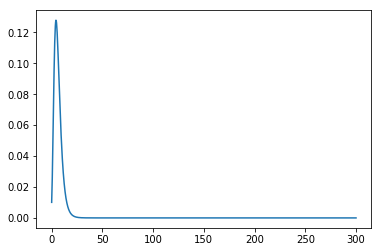

In [215]:
x_vals = np.linspace(0,300,1000)
dx = x_vals[-1] - x_vals[-2]
x_prob = stats.lognorm.pdf(x_vals, *stats.lognorm.fit(X['Wind']))
x_prob = x_prob / (dx * x_prob.sum())
fig, ax = plt.subplots()
ax.plot(x_vals, x_prob)
dx * x_prob.sum()




In [71]:
deltas = [0.01, 0.001, 0.0001]

0     0.0
1     0.0
2     0.0
3     1.0
4     1.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    1.0
11    1.0
12    0.0
13    0.0
dtype: float64